# Neural Analysis

Esta atividade consiste em identificar e classificar sinais biológicos a partir dos dados obtidos por meio de um equipamento que realiza a medição de sinais neurais de pessoas enquanto as mesmas jogavam um jogo. Tal experimento foi realizado para compor o trabalho de mestrado de Adam, do Warthog Robotics.

Tal atividade foi realizada como segundo trabalho prático da disciplina de Inteligência Artificial ministrada pela professora Solange Rezende no 1° Semestre de 2019 na USP de São Carlos.

## Introdução Teórica

Os dados obtidos consistem em sinais neurais advindos de um capacete utilizado para eletroencefalografia que utiliza o padrão 20-10 para colocação dos sensores. Desse modo, a seguinte imagem descreve a maneira com a qual os sensores estavam distribuídos na cabeça de cada um dos utilizadores.

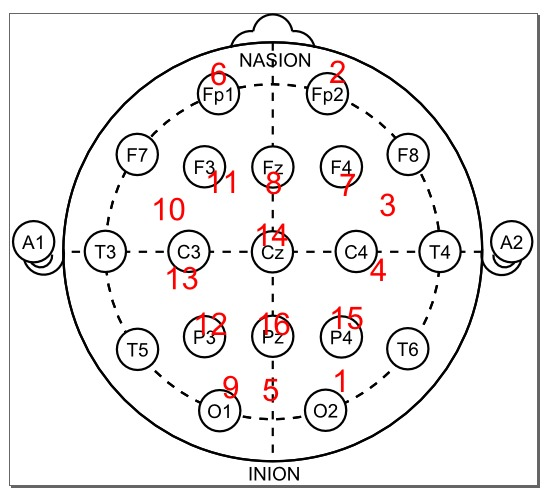

Este experimento foi realizado com 8 pessoas diferentes, cada uma delas fornece quatro bases de dados. Durante o experimento, as mesmas deveriam jogar um jogo...

O projeto consiste em:

- Identificar, de modo manual, as características que definem os sinais biológicos que queremos extrair e extrair os sinais com esses valores da nossa base.
- Clusterizar esses sinais para tentar modelar as características principais.
- Colocar esses dados em um classificador e rodar o classificador nos dados para tentar realizar a identificação automática.

Para os cabras do meu grupo, precisa fazer o seguinte:

- Filtrar piscada e olho e batida de coração.
- Jogar num K-Means e outros clusterizadores para encontrar 3 ou 4 grupos dentro dos dados que pegamos.
- Classificar e então jogar num classificador supervisionado para ele aprender.
- Rodar o classificador nos dados.
- Printar os resultados e avaliar se conseguimos ou não identificar os artefatos biológicos.

## Obtenção dos dados

Os dados estão salvos como um arquivo .csv dentro da pasta data. Eles serão importados para iniciar os trabalhos de análise dos mesmos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

warnings.simplefilter("ignore", UserWarning)

Funções para cálculo de dft, idft e filtragem de dados:

In [2]:
from scipy.signal import butter, filtfilt, group_delay, firwin, freqz

def mydft(sample_frq, time_domain):

    sample_interval = 1.0/sample_frq;
    samples = len(time_domain) # length of the signal
    k = np.arange(samples) 
    frq_range = k*(sample_frq/samples) # two sides frequency range
    frq_domain = np.fft.fft(time_domain)/samples # DFT computing and normalization

    return (frq_range, frq_domain)

def myidft(frq_domain):
    samples = len(frq_domain) # length of the signal
    time_domain = np.fft.ifft(samples*frq_domain) # Denormalization and IDFT computing
    return time_domain

def myfilter(sample_frq, time_domain, pass_interval, order=5, band_stop=False):
    if(band_stop):
        ftype = "bandstop"
    else:
        if(len(pass_interval) == 1):
            ftype = "highpass"
        elif(pass_interval[0] == 0):
            ftype = "lowpass"
        else:
            ftype = "bandpass"
    
    if(ftype == "bandpass" or ftype == "bandstop"):
        norm_frq = []
        for f in pass_interval:
            norm_frq.append(f/((sample_frq/2))) # normalizing with the nyquist frequency
    elif(ftype == "lowpass"):
        norm_frq = pass_interval[1] / (sample_frq/2)
    else:
        norm_frq = pass_interval[0] / (sample_frq/2)
        
    b = firwin(order-1, norm_frq, pass_zero=ftype)
    a = 1
    
    #b, a = butter(N=order, Wn=norm_frq, btype=ftype, analog=False)
    filtered_time_domain = filtfilt(b, a, time_domain)
    
    
    # Delay correction
    _, delay = group_delay((b, a))
    delay = int(np.round(np.mean(delay)))
    filtered_time_domain = filtered_time_domain[delay:-1]
    
    return filtered_time_domain

Definição de constantes que serão utilizadas pelo código

In [3]:
sample_rate = 512 # frequencia de amostragem, 512 Hz
blinking_signal_frq = [4, 7] # intervalo de frequências dos sinais de piscada de olho
filter_order = 1000 # ordem do filtro a ser utilizada

Leitura dos dados

In [4]:
raw_data = pd.read_csv("data/record-[2018.11.16-10.16.29].csv")
raw_data.info()
raw_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54368 entries, 0 to 54367
Data columns (total 21 columns):
Time:512Hz        54368 non-null float64
Epoch             54368 non-null int64
Channel 1         54368 non-null float64
Channel 2         54368 non-null float64
Channel 3         54368 non-null float64
Channel 4         54368 non-null float64
Channel 5         54368 non-null float64
Channel 6         54368 non-null float64
Channel 7         54368 non-null float64
Channel 8         54368 non-null float64
Channel 9         54368 non-null float64
Channel 10        54368 non-null float64
Channel 11        54368 non-null float64
Channel 12        54368 non-null float64
Channel 13        54368 non-null float64
Channel 14        54368 non-null float64
Channel 15        54368 non-null float64
Channel 16        54368 non-null float64
Event Id          34 non-null float64
Event Date        34 non-null float64
Event Duration    34 non-null float64
dtypes: float64(20), int64(1)
memory usag

,Time:512Hz,Epoch,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,...,Channel 10,Channel 11,Channel 12,Channel 13,Channel 14,Channel 15,Channel 16,Event Id,Event Date,Event Duration
0,0.000000,0,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,...,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,NaN,NaN,NaN
1,0.001953,0,9.712509e+00,9.627963e-01,9.995093e-01,9.712509e+00,9.712509e+00,3.329517e-01,1.024203e+00,1.050531e+00,...,1.359975e+01,2.871954e+00,9.712509e+00,9.712509e+00,1.295993e+00,1.373671e+00,9.712509e+00,NaN,NaN,NaN
2,0.003906,0,8.255082e+01,6.240078e+00,5.479659e+00,8.255082e+01,8.255082e+01,9.587757e-01,5.807784e+00,5.749064e+00,...,9.966038e+01,1.918641e+01,8.255082e+01,8.255082e+01,8.700532e+00,9.753357e+00,8.255082e+01,NaN,NaN,NaN
3,0.005859,0,3.220408e+02,1.860893e+01,1.280607e+01,3.220408e+02,3.220408e+02,-1.309892e+00,1.418626e+01,1.313137e+01,...,3.353348e+02,5.828425e+01,3.220408e+02,3.220408e+02,2.534720e+01,3.028059e+01,3.220408e+02,NaN,NaN,NaN
4,0.007812,0,7.760702e+02,3.310772e+01,1.680196e+01,7.760702e+02,7.760702e+02,-1.053087e+01,1.958853e+01,1.586110e+01,...,6.955557e+02,1.091119e+02,7.760702e+02,7.760702e+02,4.181824e+01,5.470015e+01,7.760702e+02,NaN,NaN,NaN
5,0.009766,0,1.304792e+03,3.798388e+01,1.468155e+01,1.304792e+03,1.304792e+03,-2.309435e+01,1.792876e+01,1.117292e+01,...,1.006323e+03,1.457051e+02,1.304792e+03,1.304792e+03,4.238638e+01,6.489718e+01,1.304792e+03,NaN,NaN,NaN
6,0.011719,0,1.614992e+03,2.914064e+01,1.181654e+01,1.614992e+03,1.614992e+03,-2.856545e+01,1.526890e+01,7.772439e+00,...,1.073737e+03,1.502217e+02,1.614992e+03,1.614992e+03,2.375708e+01,5.383020e+01,1.614992e+03,NaN,NaN,NaN
7,0.013672,0,1.471808e+03,1.763361e+01,1.181640e+01,1.471808e+03,1.471808e+03,-2.162669e+01,1.818212e+01,1.236743e+01,...,8.369688e+02,1.196093e+02,1.471808e+03,1.471808e+03,-4.904597e+00,3.089755e+01,1.471808e+03,NaN,NaN,NaN
8,0.015625,0,9.060320e+02,1.493347e+01,1.184464e+01,9.060320e+02,9.060320e+02,-8.278406e+00,2.394179e+01,1.952693e+01,...,4.129697e+02,6.896184e+01,9.060320e+02,9.060320e+02,-3.261229e+01,9.888023e+00,9.060320e+02,NaN,NaN,NaN
9,0.017578,0,2.263633e+02,1.968124e+01,1.097778e+01,2.263633e+02,2.263633e+02,3.060367e-01,2.703347e+01,2.193512e+01,...,2.606730e+01,3.123114e+01,2.263633e+02,2.263633e+02,-4.861875e+01,-7.347121e-02,2.263633e+02,NaN,NaN,NaN


## Tratamento de dados

Como foi possível observar, existem três colunas (Event Id, Event Date e Event Duration) que possuem valores nulos para todas as entradas, além disso, conforme exposto na introdução teórica, alguns sensores podem ser desconsiderados.   
Além disso a época da medição também será desconsiderada, uma vez que pode ser extrapolada do tempo se necessário.

In [5]:
# Remocao de colunas nao utilizadas
data = raw_data.drop(["Event Id",
                      "Event Date",
                      "Event Duration",
                      "Epoch",
                      "Channel 1",
                      "Channel 4",
                      "Channel 5",
                      "Channel 9",
                      "Channel 12",
                      "Channel 13",
                      "Channel 16"], axis=1)
# Separacao da coluna de tempo
time_data = data["Time:512Hz"]
data = data.drop(["Time:512Hz"], axis=1)
data

,Channel 2,Channel 3,Channel 6,Channel 7,Channel 8,Channel 10,Channel 11,Channel 14,Channel 15
0,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10
1,9.627963e-01,9.995093e-01,3.329517e-01,1.024203e+00,1.050531e+00,1.359975e+01,2.871954e+00,1.295993e+00,1.373671e+00
2,6.240078e+00,5.479659e+00,9.587757e-01,5.807784e+00,5.749064e+00,9.966038e+01,1.918641e+01,8.700532e+00,9.753357e+00
3,1.860893e+01,1.280607e+01,-1.309892e+00,1.418626e+01,1.313137e+01,3.353348e+02,5.828425e+01,2.534720e+01,3.028059e+01
4,3.310772e+01,1.680196e+01,-1.053087e+01,1.958853e+01,1.586110e+01,6.955557e+02,1.091119e+02,4.181824e+01,5.470015e+01
5,3.798388e+01,1.468155e+01,-2.309435e+01,1.792876e+01,1.117292e+01,1.006323e+03,1.457051e+02,4.238638e+01,6.489718e+01
6,2.914064e+01,1.181654e+01,-2.856545e+01,1.526890e+01,7.772439e+00,1.073737e+03,1.502217e+02,2.375708e+01,5.383020e+01
7,1.763361e+01,1.181640e+01,-2.162669e+01,1.818212e+01,1.236743e+01,8.369688e+02,1.196093e+02,-4.904597e+00,3.089755e+01
8,1.493347e+01,1.184464e+01,-8.278406e+00,2.394179e+01,1.952693e+01,4.129697e+02,6.896184e+01,-3.261229e+01,9.888023e+00
9,1.968124e+01,1.097778e+01,3.060367e-01,2.703347e+01,2.193512e+01,2.606730e+01,3.123114e+01,-4.861875e+01,-7.347121e-02


## Análise dos dados

Agora, será feita a análise dos dados para identificar potenciais características que possam ser úteis.

In [6]:
data.describe()

,Channel 2,Channel 3,Channel 6,Channel 7,Channel 8,Channel 10,Channel 11,Channel 14,Channel 15
count,54368.000000,54368.000000,54368.000000,54368.000000,54368.000000,5.436800e+04,54368.000000,54368.000000,5.436800e+04
mean,-0.013096,-0.009231,-0.008227,-0.002957,-0.007283,-5.441568e+02,-0.012100,-0.018008,2.356203e-01
std,21.478698,12.724242,28.085758,13.479121,12.707252,2.302041e+06,40.582380,58.452470,3.257964e+06
min,-187.835399,-76.348755,-227.950777,-81.716186,-73.165099,-1.126000e+08,-248.725058,-302.143497,-1.126364e+08
25%,-9.329721,-7.818604,-14.771281,-7.452788,-7.917409,-2.597097e+02,-27.345459,-35.476604,-4.415345e+01
50%,0.320513,0.051918,0.604290,-0.020273,-0.059509,-8.681819e+00,0.210433,-1.018705,-1.347237e+00
75%,9.726748,7.765726,15.536110,7.557038,8.068467,2.435193e+02,27.230811,33.918042,4.166985e+01
max,161.200798,88.293258,207.852728,84.469622,62.570607,3.667353e+07,269.009659,375.423734,1.126231e+08


Inicialmente os dados serão expostos no domínio do tempo, antes de qualquer filtragem.

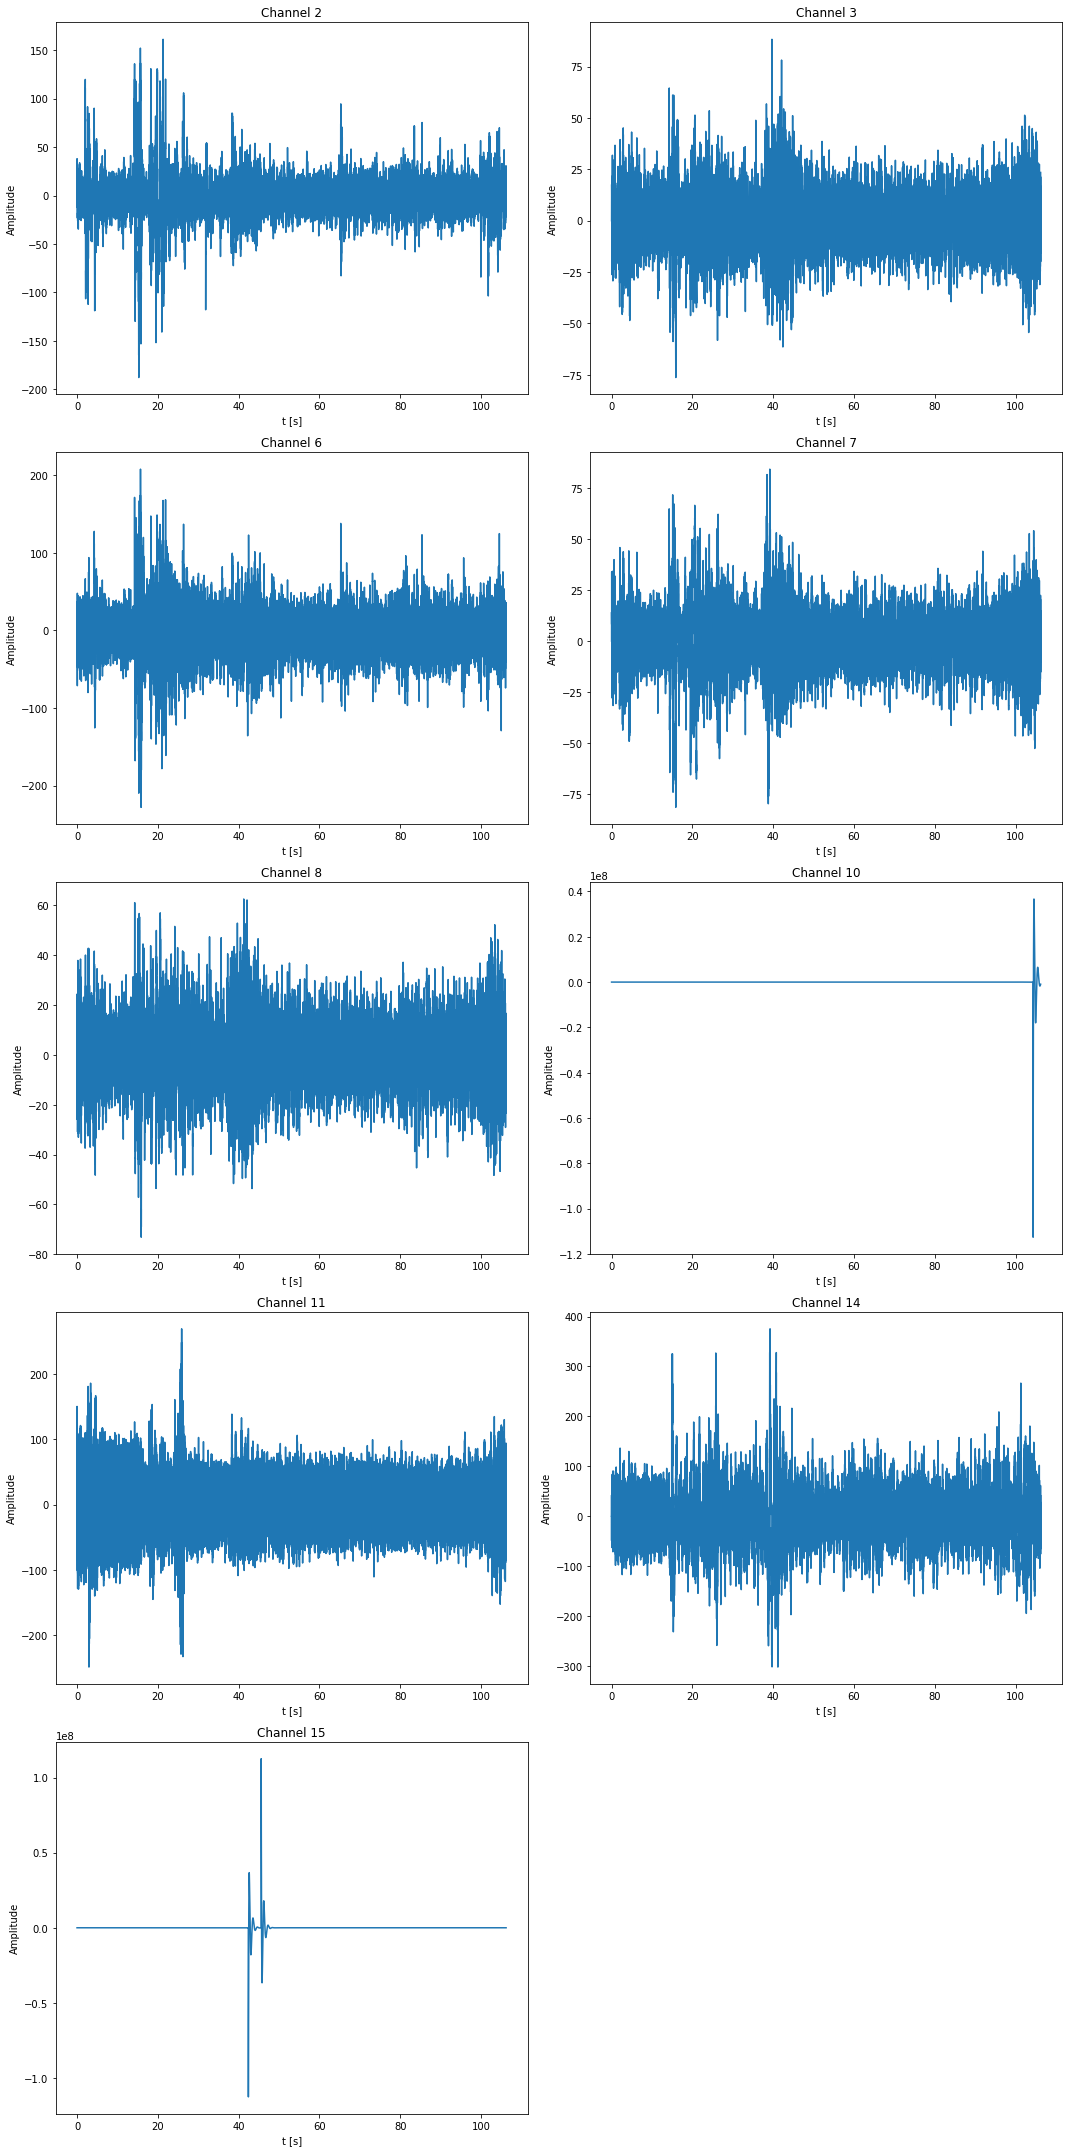

In [7]:
fig, ax = plt.subplots(5, 2, figsize=(15,30))
line = 0
column = 0
for key in data:
    ax[line][column].plot(time_data, data[key])
    ax[line][column].set_title(key)
    ax[line][column].set_xlabel("t [s]")
    ax[line][column].set_ylabel("Amplitude")
    if(column == 1):
        line += 1
        column = 0
    else:
        column = 1
    
fig.delaxes(ax[4][1])
plt.tight_layout()


Agora será calculada a transformada discreta de Fourier de cada canal para caracterizar os canais no domínimo da frequência.

In [8]:
frq_data = pd.DataFrame()
frq_range = None # este valor sera o mesmo para todos os canais, como a taxa de amostragem e a mesma
for key in data:
    frq_range, frq_data[key] = mydft(sample_rate, data[key])
    
frq_data

,Channel 2,Channel 3,Channel 6,Channel 7,Channel 8,Channel 10,Channel 11,Channel 14,Channel 15
0,(-0.013095835458497825+0j),(-0.009230560851004323+0j),(-0.008226871695913029+0j),(-0.0029569573311433086+0j),(-0.00728341318496536+0j),(-544.1567961710717+0j),(-0.012099797267775207+0j),(-0.018007793788660874+0j),(0.23562031491623983+0j)
1,(-0.013096186978979794-4.3894344636375004e-05j),(-0.009231886866272214+2.809285988667442e-06j),(-0.008229411506320783-3.0725605981844654e-05j),(-0.0029640293626555184+2.758670874251708e-06j),(-0.007283846446565773-3.7757598434490546e-06j),(-544.0971319300263+17.037416667789937j),(-0.012102574851756295-1.3303066760614223e-05j),(-0.01803641754129359+5.799358326996034e-05j),(0.25636279987995253+0.010839886000618339j)
2,(-0.013102039616402252-9.398769942646734e-05j),(-0.009225137666971446-2.370089973303798e-05j),(-0.008193839469845718-7.774494624812362e-05j),(-0.002912323750094913-5.071879955680169e-05j),(-0.00728386868817914-1.5078056951558179e-05j),(-544.0506807079562+34.82524495254659j),(-0.012136958551470728-5.207838673113747e-05j),(-0.018000667881507452+2.552803817054836e-05j),(0.03983917465288807-0.3265317971895555j)
3,(-0.013105210650277347-0.0001253193991956733j),(-0.009299267295737053+2.0239763776200855e-05j),(-0.008324428854397088-0.00020392629838262555j),(-0.0031389168198260324-6.567204105239803e-05j),(-0.007314148334876151-3.183397179102376e-05j),(-544.3954957706559+54.06455316939204j),(-0.012187996896484641+8.86308640018991e-06j),(-0.018312557706160824-0.00021554992904126492j),(0.2877423779645351+1.9021273634207254j)
4,(-0.013152246583073644-0.00022319086982087547j),(-0.009170111967949814-2.786736982964997e-05j),(-0.008191142143173567+7.473721626327358e-05j),(-0.0027905985592555703+0.00016075899263064112j),(-0.00731538168708164-3.0831211234272875e-05j),(-545.7779619721282+75.3083519876924j),(-0.012256768998514717-0.00019113435437634107j),(-0.018122268269911142+4.541617139572781e-05j),(3.0219142237268666-5.26834489592292j)
5,(-0.01326197909881229-0.00011835343589785284j),(-0.009462034447196179-2.4346951741647678e-05j),(-0.008019446859374784-0.0005186406034387353j),(-0.003011505772840384-0.0005482286651276259j),(-0.00731038829905309-0.00011262420355899241j),(-549.029624518781+99.06900725806892j),(-0.012644195645279119+6.707206798170388e-05j),(-0.019180336396501838-0.001306470760300638j),(-11.854638907141766+7.733697264491517j)
6,(-0.013054341063202041-0.00014581580549822098j),(-0.009074010537494058+0.00016136385490148872j),(-0.008858477365442801-8.72251668012831e-05j),(-0.0035037908620666617+0.0004865185748116399j),(-0.00737797777100051-5.6987784698128824e-05j),(-555.1134140885123+125.37276818440952j),(-0.01214945226687849-0.0004336640543872226j),(-0.01743202853916271+0.002633941269716964j),(29.452488827202274-1.605459179177245j)
7,(-0.013251782174607402-0.0004687462398655674j),(-0.00940815320442769-0.0004704493618581783j),(-0.007017822871749908-6.434916171133816e-05j),(-0.0016238909468888046-0.00028227070420713075j),(-0.007097503132796124-0.00011989994820121859j),(-565.4576095233739+154.41440842723065j),(-0.0135479966818482-0.0010487362000114165j),(-0.01628645138222495-0.0032479779686829364j),(-47.413719803131485-23.58987996033253j)
8,(-0.013161553325915846-9.48514944690963e-06j),(-0.009549035468573813+0.000496879008090736j),(-0.009116777381704851-0.0019031312159013087j),(-0.004329258355476603-0.0012863883565144714j),(-0.007555921545663883-1.4928490675873634e-05j),(-580.8087736105548+185.75642382221244j),(-0.013524835603378742+0.0010604120275686123j),(-0.01788906221517154+0.0026459360530916316j),(50.013820975611914+73.3191905444639j)
9,(-0.013422343825044543-0.001055831183155186j),(-0.009118257223641811-0.000580490584897041j),(-0.009255236969018895+0.001837598598335459j),(-0.0029733383181452296+0.002179717671860218j),(-0.007510210954128074+0.00012968597999758576j),(-603.1370708662432+218.51830176830296j),(-0.012361788556575473-0.001032110413302045j),(-0.009178499411987626-0.00283824936778

Uma forma mais simples de se visualizar a informação dos sinais em frequência é por meio do diagrama de Bode, contendo ganho de um sinal no domínio da frequência, isso será feito a seguir:

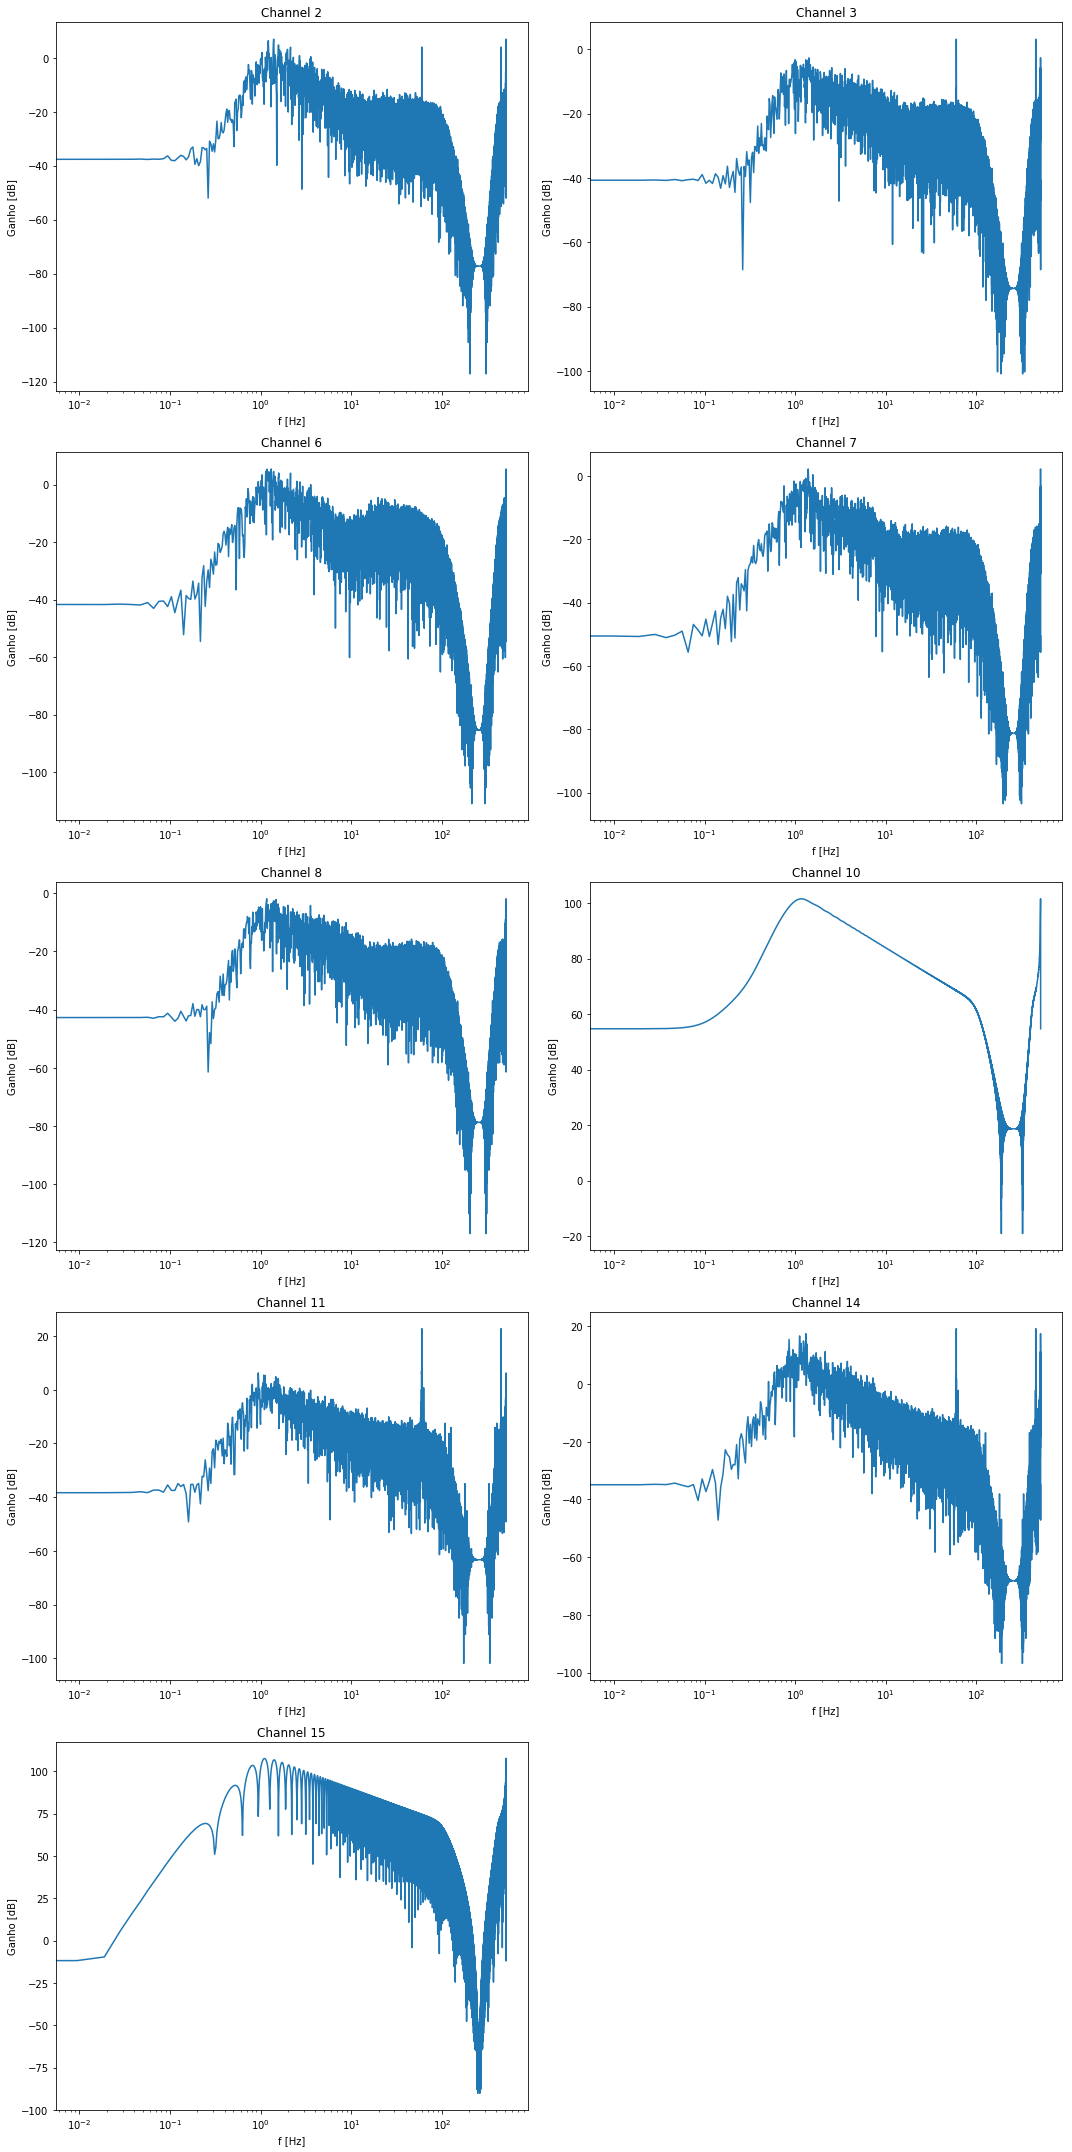

In [9]:
fig, ax = plt.subplots(5, 2, figsize=(15,30))
line = 0
column = 0
for key in frq_data:
    ax[line][column].semilogx(frq_range, 20*(np.log(abs(frq_data[key]))/np.log(10)))
    ax[line][column].set_title(key)
    ax[line][column].set_xlabel("f [Hz]")
    ax[line][column].set_ylabel("Ganho [dB]")
    if(column == 1):
        line += 1
        column = 0
    else:
        column = 1
    
fig.delaxes(ax[4][1])
plt.tight_layout()

## Extraindo os dados com filtro
Serão extraídos os dados na faixa de frequências em que a piscada ocorre, de 4 Hz a 7 Hz.      
Isso será feito com um filtro FIR de ordem 1000.

In [10]:
# Filtragem dos dados:
filtered_data = pd.DataFrame()
for key in data:
    filtered_data[key] = myfilter(sample_rate, data[key], blinking_signal_frq, filter_order)

Como os dados passaram por um filtro, é possível que certos pontos tenham sido descartados para compensar o atraso causado pelo filtro, por isso, deve-se definir um novo eixo de tempo para os dados filtrados:

In [11]:
filtered_time_data = time_data[0:(len(filtered_data[filtered_data.keys()[0]]))]

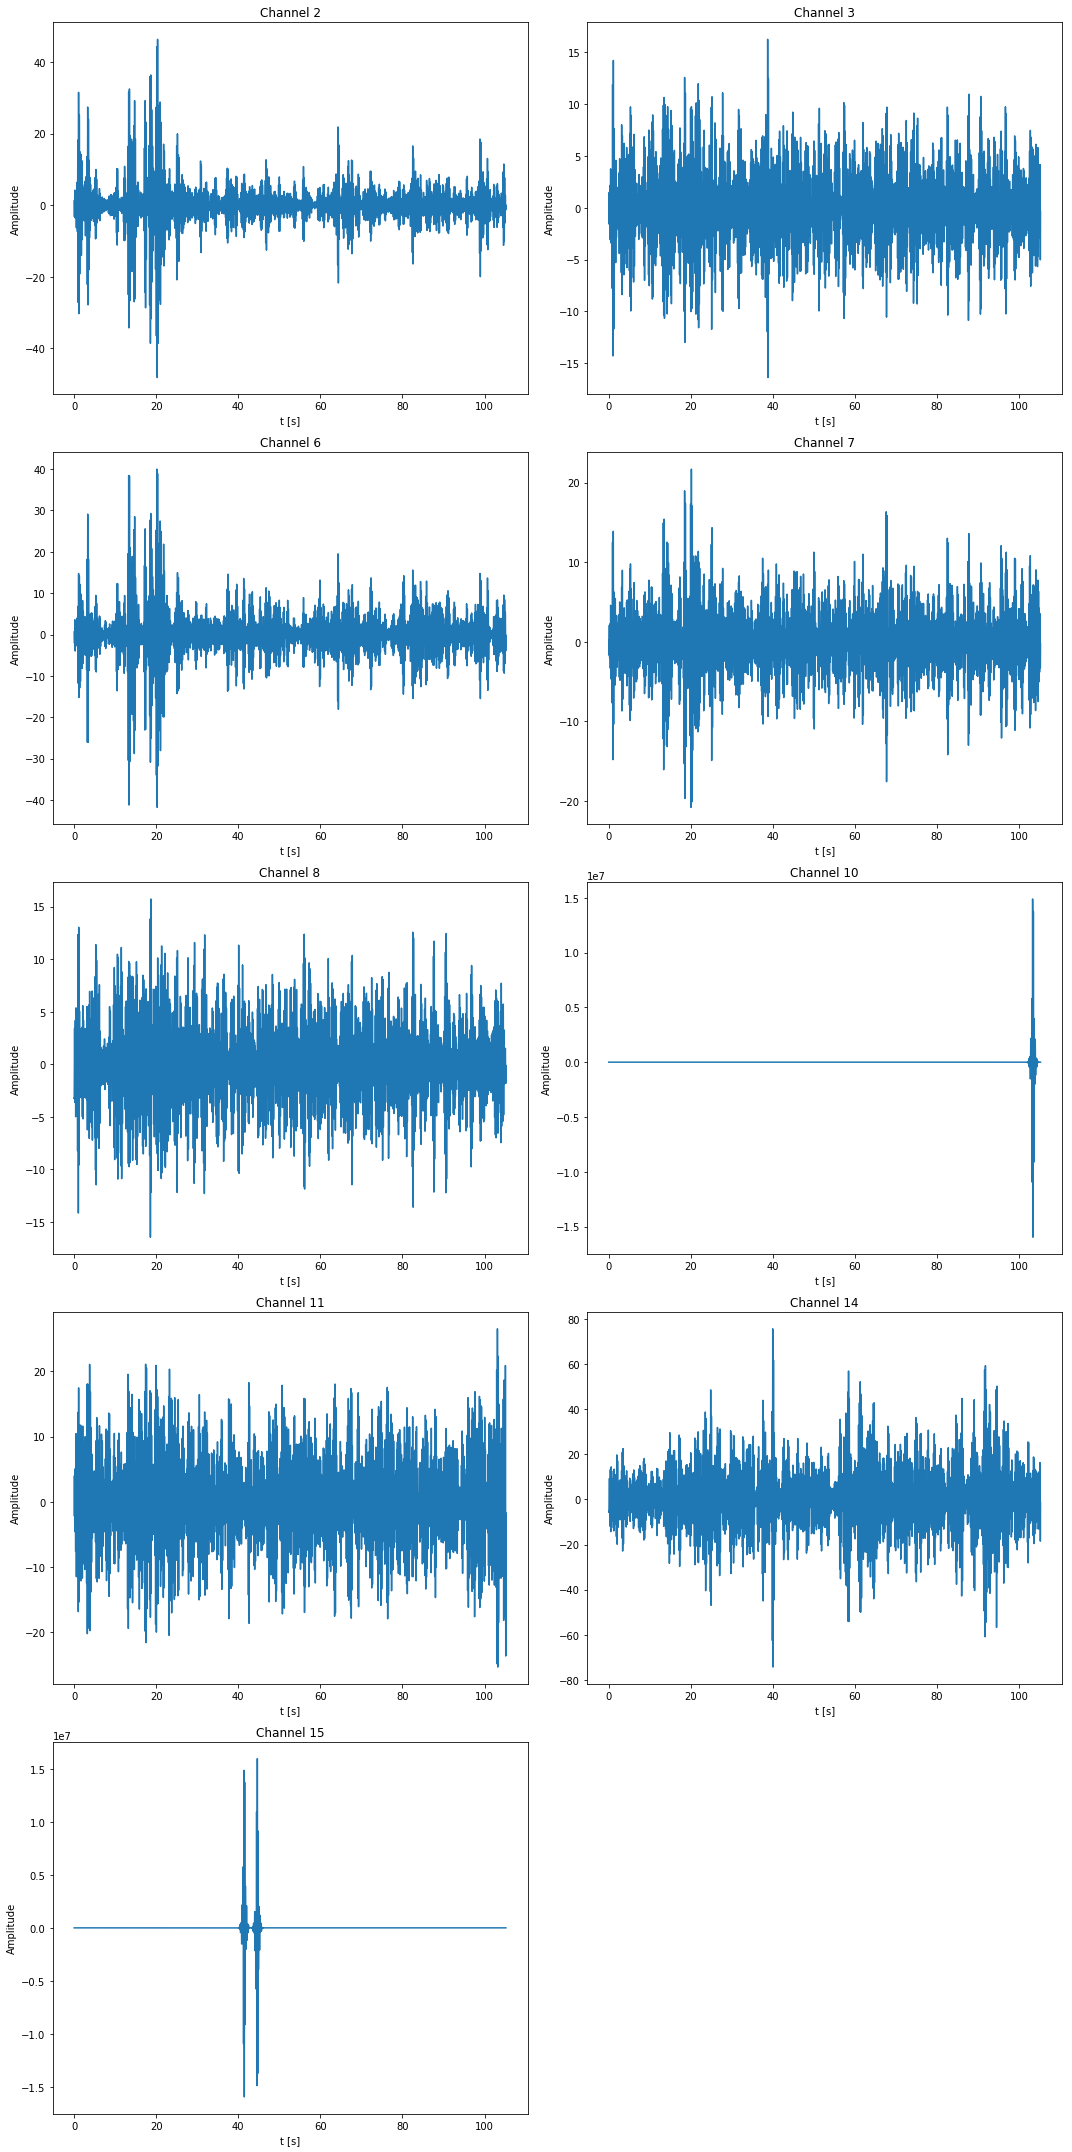

In [12]:
# Impressao dos dados:
fig, ax = plt.subplots(5, 2, figsize=(15,30))
line = 0
column = 0
for key in filtered_data:
    ax[line][column].plot(filtered_time_data, filtered_data[key])
    ax[line][column].set_title(key)
    ax[line][column].set_xlabel("t [s]")
    ax[line][column].set_ylabel("Amplitude")
    if(column == 1):
        line += 1
        column = 0
    else:
        column = 1
    
fig.delaxes(ax[4][1])
plt.tight_layout()

Análise em frequência dos dados filtrados:

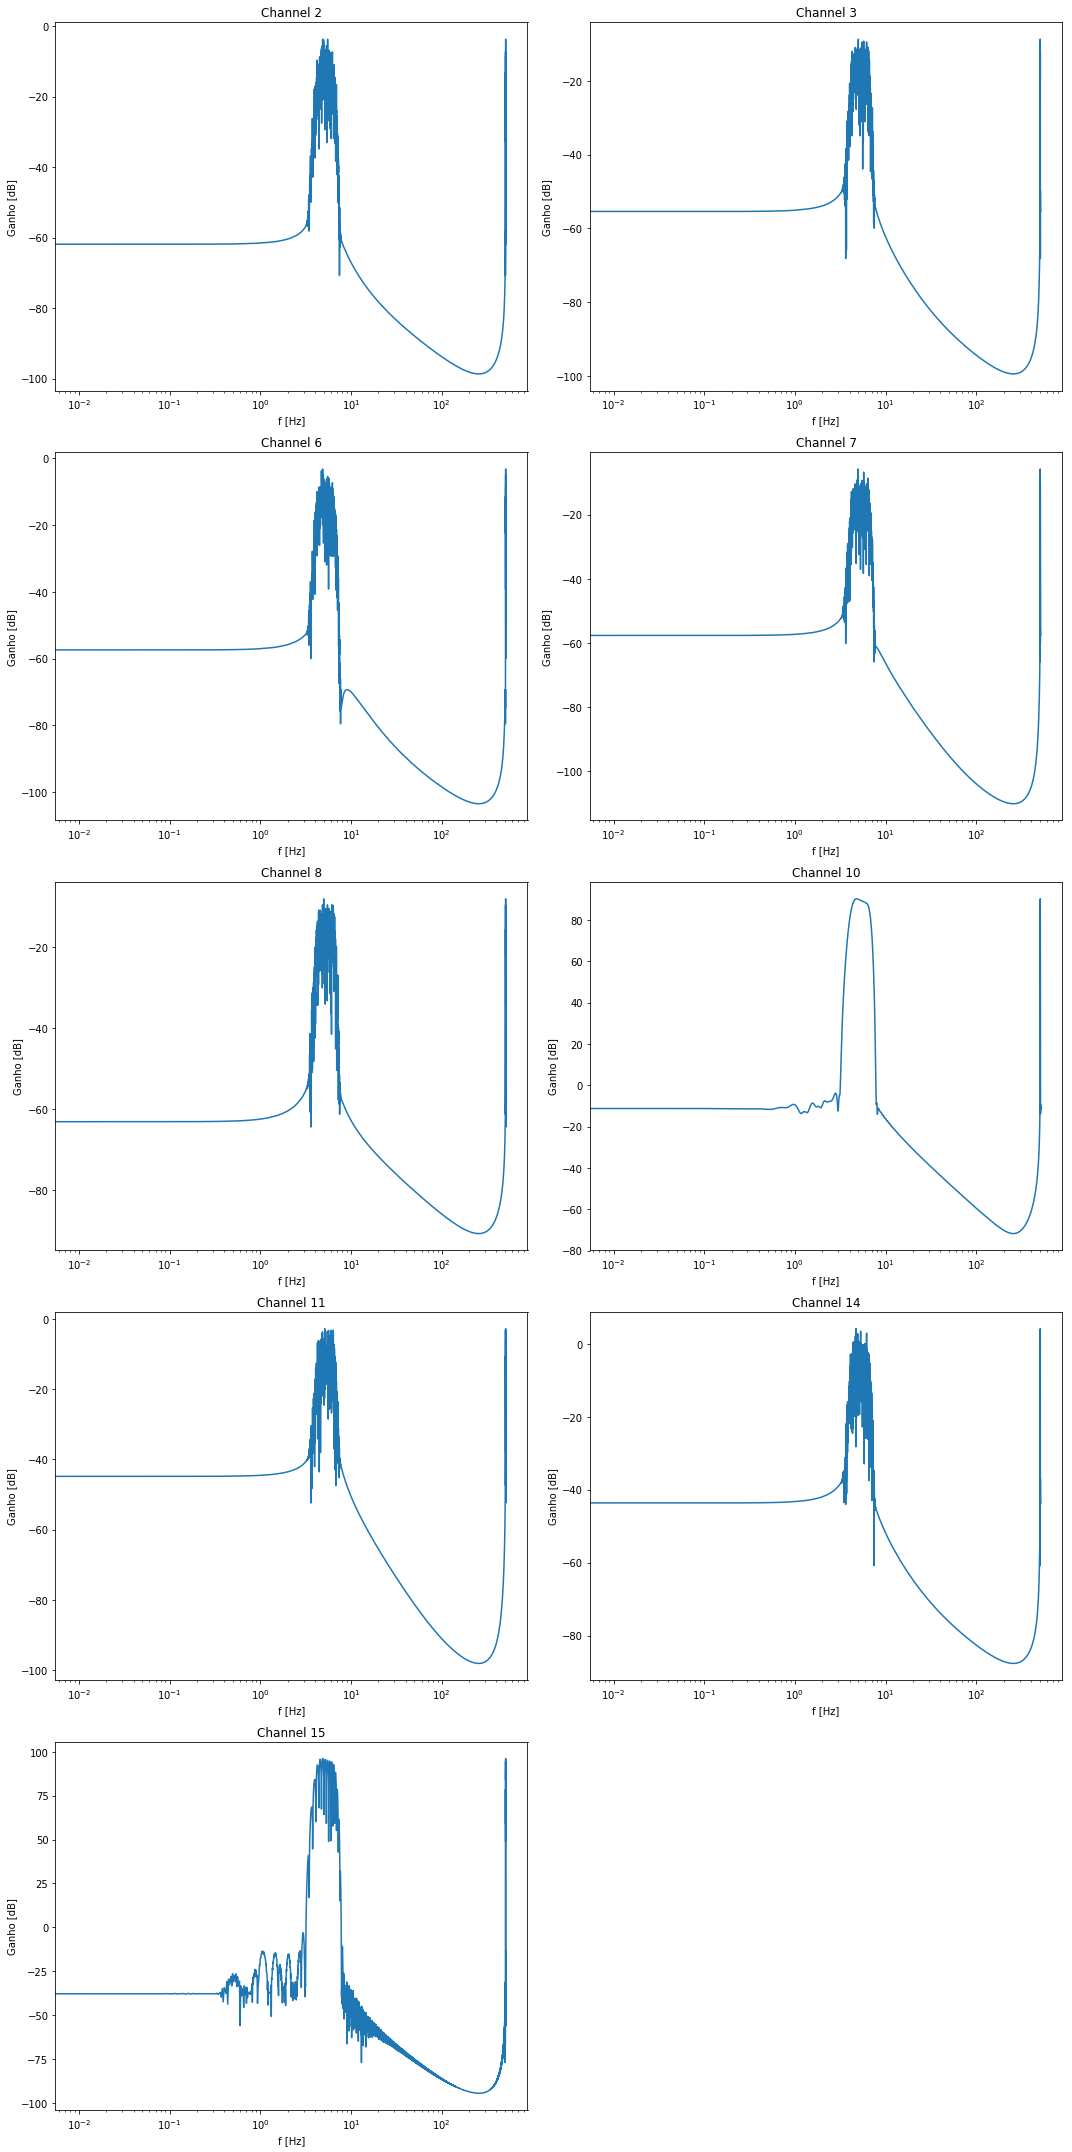

In [13]:
filtered_frq_data = pd.DataFrame()
filtered_frq_range = None # este valor sera o mesmo para todos os canais, como a taxa de amostragem e a mesma
for key in filtered_data:
    filtered_frq_range, filtered_frq_data[key] = mydft(sample_rate, filtered_data[key])

fig, ax = plt.subplots(5, 2, figsize=(15,30))
line = 0
column = 0
for key in filtered_frq_data:
    ax[line][column].semilogx(filtered_frq_range, 20*(np.log(abs(filtered_frq_data[key]))/np.log(10)))
    ax[line][column].set_title(key)
    ax[line][column].set_xlabel("f [Hz]")
    ax[line][column].set_ylabel("Ganho [dB]")
    if(column == 1):
        line += 1
        column = 0
    else:
        column = 1
    
fig.delaxes(ax[4][1])
plt.tight_layout()

Acima pode ser observado que o sinal foi bastante atenuado para frequências fora da faixa que se deseja estudar.